## Import Necessary Libraries

In [18]:
pip install tensorflow

In [20]:
pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [19]:
from tensorflow.keras import regularizers
from keras.regularizers import l2
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## Load Saved Preprocessed Data

In [6]:

path = '/content/drive/MyDrive/MSc Dissertation'
df_shuffled=pd.read_csv(path + '/df_shuffled.csv')

In [7]:
# Split dataset into features and labels
X = df_shuffled['df_cleaned']
y = df_shuffled['class']
#X = df['tweet'].values
#y = df['class'].values

In [8]:
df_shuffled = df_shuffled.dropna()

# Load Glove Embeddings

In [9]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2024-09-13 09:12:28--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2024-09-13 09:12:28--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2024-09-13 09:12:28--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

## Exploring LSTM on Original Dataset with Different Parameters

In [9]:
# Load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Loading GloVe {embedding_dim}d"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

# Define the dimensions and file paths
glove_files = {
    #25: 'glove.twitter.27B.25d.txt',
    #50: 'glove.twitter.27B.50d.txt',
    100: 'glove.twitter.27B.100d.txt',
    #200: 'glove.twitter.27B.200d.txt'
}

# Load all embeddings
glove_embeddings = {}
for dim, file_path in glove_files.items():
    glove_embeddings[dim] = load_glove_embeddings(file_path, dim)

# Assume df_shuffled is your DataFrame with 'df_cleaned' and 'class' columns
X = df_shuffled['df_cleaned']  # Features: cleaned text data
y = df_shuffled['class']       # Labels: target class

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenize the text
max_words = 30000  # Maximum number of words to keep
max_len = 128  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Prepare embedding matrix
embedding_dim = 100  # Choose the embedding dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings[embedding_dim].get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build LSTM model
model = Sequential([
    Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, np.array(y_train),
                    validation_data=(X_val_pad, np.array(y_val)),
                    epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_pad, np.array(y_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nTesting Classification Report:")
print(classification_report(y_test, y_pred))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Loading GloVe embeddings (100d)...


Loading GloVe 100d: 1193514it [01:00, 19889.44it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 459s 437ms/step - accuracy: 0.8510 - loss: 0.3202 - val_accuracy: 0.8663 - val_loss: 0.2802
Epoch 2/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 512s 447ms/step - accuracy: 0.8702 - loss: 0.2693 - val_accuracy: 0.8675 - val_loss: 0.2663
Epoch 3/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 478s 423ms/step - accuracy: 0.8771 - loss: 0.2548 - val_accuracy: 0.8752 - val_loss: 0.2591
Epoch 4/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 449s 430ms/step - accuracy: 0.8846 - loss: 0.2404 - val_accuracy: 0.8725 - val_loss: 0.2595
Epoch 5/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 513s 441ms/step - accuracy: 0.8929 - loss: 0.2243 - val_accuracy: 0.8701 - val_loss: 0.2604
Epoch 6/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 504s 443ms/step - accuracy: 0.8964 - loss: 0.2110 - val_accuracy: 0.8666 - val_loss: 0.2679
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.8850 - loss: 0.2496
Test Accuracy: 0.8811
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 126ms/step

Testing Classification Report:
              precis

# Best Performing Network

Loading GloVe embeddings (100d)...


Loading GloVe 100d: 1193514it [00:57, 20685.23it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 483s 460ms/step - accuracy: 0.8473 - loss: 0.4516 - val_accuracy: 0.8616 - val_loss: 0.3162
Epoch 2/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 502s 460ms/step - accuracy: 0.8575 - loss: 0.3214 - val_accuracy: 0.8618 - val_loss: 0.3048
Epoch 3/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 497s 455ms/step - accuracy: 0.8624 - loss: 0.3011 - val_accuracy: 0.8637 - val_loss: 0.3020
Epoch 4/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 482s 436ms/step - accuracy: 0.8625 - loss: 0.3002 - val_accuracy: 0.8658 - val_loss: 0.2994
Epoch 5/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 479s 464ms/step - accuracy: 0.8670 - loss: 0.2969 - val_accuracy: 0.8661 - val_loss: 0.2980
Epoch 6/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 494s 456ms/step - accuracy: 0.8650 - loss: 0.2982 - val_accuracy: 0.8690 - val_loss: 0.2987
Epoch 7/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 459s 444ms/step - accuracy: 0.8700 - loss: 0.2970 - val_accuracy: 0.8664 - val_loss: 0.2933
Epoch 8/20
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 507s 448ms/step - ac

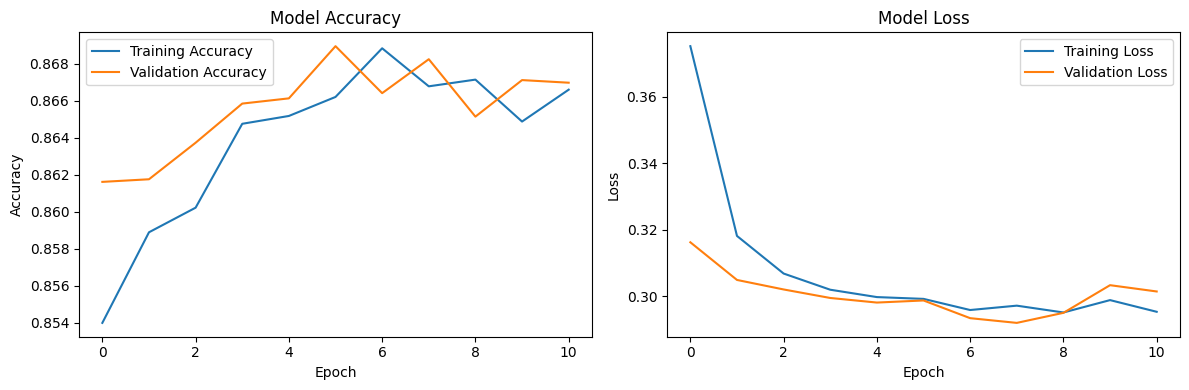

In [10]:
# Additions: kernel_regularizer=l2(0.001), patience change from 5 to 3.

# Load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Loading GloVe {embedding_dim}d"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

# Define the dimensions and file paths
glove_files = {
    #25: 'glove.twitter.27B.25d.txt',
    #50: 'glove.twitter.27B.50d.txt',
    100: 'glove.twitter.27B.100d.txt',
    #200: 'glove.twitter.27B.200d.txt'
}

# Load all embeddings
glove_embeddings = {}
for dim, file_path in glove_files.items():
    glove_embeddings[dim] = load_glove_embeddings(file_path, dim)

# Assume df_shuffled is your DataFrame with 'df_cleaned' and 'class' columns
X = df_shuffled['df_cleaned']  # Features: cleaned text data
y = df_shuffled['class']       # Labels: target class

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenize the text
max_words = 5000  # Maximum number of words to keep
max_len = 128  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Prepare embedding matrix
embedding_dim = 100  # Choose the embedding dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings[embedding_dim].get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build LSTM model
model = Sequential([
    Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=True,
    kernel_regularizer=l2(0.001),
    recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=l2(0.001), recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu',  kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, np.array(y_train),
                    validation_data=(X_val_pad, np.array(y_val)),
                    epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_pad, np.array(y_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nTesting Classification Report:")
print(classification_report(y_test, y_pred))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Trained on 50D

Loading GloVe embeddings (50d)...


Loading GloVe 50d: 1193514it [00:34, 35013.73it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 461s 440ms/step - accuracy: 0.8461 - loss: 0.3350 - val_accuracy: 0.8654 - val_loss: 0.2835
Epoch 2/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 519s 457ms/step - accuracy: 0.8675 - loss: 0.2776 - val_accuracy: 0.8666 - val_loss: 0.2728
Epoch 3/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 482s 437ms/step - accuracy: 0.8762 - loss: 0.2602 - val_accuracy: 0.8715 - val_loss: 0.2673
Epoch 4/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 490s 425ms/step - accuracy: 0.8823 - loss: 0.2513 - val_accuracy: 0.8706 - val_loss: 0.2656
Epoch 5/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 470s 454ms/step - accuracy: 0.8873 - loss: 0.2369 - val_accuracy: 0.8708 - val_loss: 0.2652
Epoch 6/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 511s 462ms/step - accuracy: 0.8858 - loss: 0.2308 - val_accuracy: 0.8692 - val_loss: 0.2619
Epoch 7/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 465s 427ms/step - accuracy: 0.8958 - loss: 0.2150 - val_accuracy: 0.8712 - val_loss: 0.2624
Epoch 8/50
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 451s 436ms/step - ac

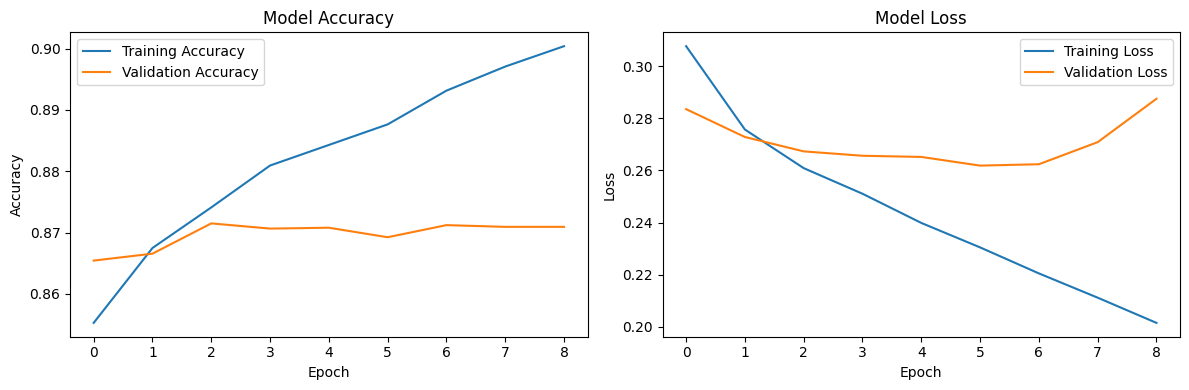

In [12]:
# Load GloVe embeddings,
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Loading GloVe {embedding_dim}d"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

# Define the dimensions and file paths
glove_files = {
    #25: 'glove.twitter.27B.25d.txt',
    50: 'glove.twitter.27B.50d.txt',
    #100: 'glove.twitter.27B.100d.txt',
    #200: 'glove.twitter.27B.200d.txt'
}

# Load all embeddings
glove_embeddings = {}
for dim, file_path in glove_files.items():
    glove_embeddings[dim] = load_glove_embeddings(file_path, dim)

# Assume df_shuffled is your DataFrame with 'df_cleaned' and 'class' columns
X = df_shuffled['df_cleaned']  # Features: cleaned text data
y = df_shuffled['class']       # Labels: target class

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenize the text
max_words = 30000  # Maximum number of words to keep
max_len = 128  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Prepare embedding matrix
embedding_dim = 50  # Choose the embedding dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings[embedding_dim].get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build LSTM model
model = Sequential([
    Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, np.array(y_train),
                    validation_data=(X_val_pad, np.array(y_val)),
                    epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_pad, np.array(y_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nTesting Classification Report:")
print(classification_report(y_test, y_pred))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()